In [1]:
import sys
try:
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
except:
    import pip
    pip.main(['install', "--upgrade", "pip"])
    pip.main(['install', "numpy"])
    pip.main(['install', "matplotlib"])
    pip.main(['install', "ipython"])
    pip.main(['install', "jupyter"])
    pip.main(['install', "pandas"])
    import numpy as np
    import pandas as pd
    
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%load_ext autoreload
%autoreload 2

## Importing the data
We use the pandas library for this. The data is split into 3 files:
- sample.csv :: Some stuff we can look at to know how the bigger and slower-to-load datafiles look like
- test.csv :: Validation data, which we use to 'grade' our model by
- train.csv :: Data we use to train our model with (to find the 'optimal' parameters)

In [2]:
data_sample = pd.read_csv('sample.csv')
data_test = pd.read_csv('test.csv')
data_train = pd.read_csv('train.csv')

cases = 1
if True:
    print("Sample")
    print(data_sample.head(cases))
    print("Test")
    print(data_test.head(cases))
    print("Train")
    print(data_train.head(cases))

Sample
    Id         y
0  900  6.055126
Test
    Id        x1        x2       x3       x4        x5        x6        x7  \
0  900  0.658913  1.489215  1.65309  2.68705  0.613798  1.599903  1.345002   

         x8       x9       x10       x11       x12       x13       x14  \
0  1.617774 -0.48859  2.893903  3.800831 -0.018902  0.857224  0.881235   

       x15  
0  0.57476  
Train
   Id           y        x1        x2        x3        x4       x5        x6  \
0   0  116.376061  1.276266 -0.854628  1.623901  2.145311  2.03719  2.886639   

         x7        x8        x9       x10       x11      x12       x13  \
0  0.888302  0.637899  1.148675  0.562217  3.171257  2.15231 -0.818812   

        x14      x15  
0  0.861951  1.53984  


The data contains 'headers' (Thing like 'Id', 'y', 'x1', 'x2', etc.). For pure data processing we need to get rid of this (because these are not numebrs), and just retrieve the numerical values within the matrices. CV stands for cross-validation. Printing the shapes is just to make sure the import was successful.

In [3]:
X_data = data_train.values
y_sample = data_sample.values
X_test = data_test.values[:,1:]

if True:
    print("X_train")
    print(X_data.shape)
    print("y_sample")
    print(y_sample.shape)
    print("X_finaltest")
    print(X_test.shape)

    print("And has types")
    print(type(X_test[0,0]))

X_train
(900, 17)
y_sample
(2000, 2)
X_finaltest
(2000, 15)
And has types
<type 'numpy.float64'>


## Function Definitions and Applications
Here we define the functions we will use to predict the weights (normalEq, or maybe even stochastic gradient descent), and also the given error function (rms). Trying out different algorithms and testing them through cross-validation. Look at the external files for the algorithms.

### Normal Equations 
#### with regulaizer parameters = lam
We test a total of 10000 different values for lambda in between 1e-20 and 1e10

In [41]:
from helper import *
from normalEq import *

k = 5 #number of folds for cross validation

if X_data.shape[0] % k != 0:
    print("Number of samples not divisible by k!")
    sys.exit(0)
    
print("Total samples: ", X_data.shape[0])

total_error = 0.0

X = np.split(X_data[:,2:], k, axis=0)
y = np.split(X_data[:,1], k, axis=0)

print(X[0].shape)
print(y[0].shape)

loss_dict = []
lam_dict = []

lam_range = np.logspace(-16, 10, num=10000)#[1e-8, 1e-3, 1e2]

#Apply cross validation
for lam in lam_range:
    loss = 0
    for i in range(k):
        X_train, y_train, X_cv, y_cv = get_train_cross_dataset(X, y, i)

        #apply to training function, then measure the error
        weights = reg_normal_eq(X_train, y_train, lam)
        
        ##Measure loss
        predictions = np.dot(X_cv, weights)
        loss = rms(predictions, y_cv)    
    
    total_error += loss    
    total_error /= k
    
    lam_dict.append(lam)
    loss_dict.append(total_error)    
    

('Total samples: ', 900)
(180, 15)
(180,)


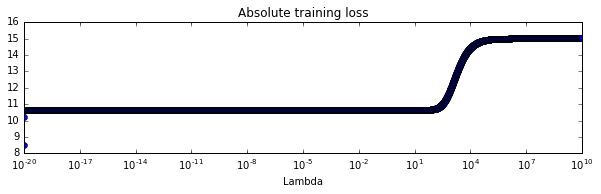

In [39]:
plt.subplot(3, 1, 1)
plt.title('Absolute training loss')
plt.xlabel('Lambda')
plt.semilogx(lam_dict, loss_dict, 'o')
#plt.plot(lam_dict, 'o', label='baseline')
#plt.plot(loss_dict, 'o', label='batchnorm')
plt.show()

In [40]:
print("The minimal error is given when lambda equals: ", lam_dict[loss_dict.index(min(loss_dict))])

('The minimal error is given when lambda equals: ', 9.9999999999999995e-21)


### Gradient Descent

First of all, let's check if gradient descent actually works

In [50]:
lr = 0.1
mu = 0.1

w = np.random.normal(0.0, 1.0, size=(X_train.shape[1])) #must be adaptable to X

train_loss_list, cv_loss_list, w = run_sgd(X[0], y[0], X[1], y[1], w, mu, lr, rms, MAX_STEPS=50)

print(train_loss_list)
print(cv_loss_list)


[62.70974060611794, 58.626114722632352, 55.28611880480711, 52.589690541811763, 50.344400093073105, 48.502512186769209, 46.959636962966783, 45.68352562886885, 44.61225597392481, 43.721163121371198, 42.971663126484181, 42.344932699404637, 41.816312631799704, 41.371852621181176, 40.995551950714827, 40.677332657811334, 40.406686586622662, 40.176452894486076, 39.979649729037199, 39.811232666202478, 39.66650686243014, 39.541928181533358, 39.434300490010315, 39.34112969171079, 39.260212624586003, 39.189786026242402, 39.128312196267125, 39.074536208492738, 39.027371559335506, 38.98591787249557, 38.949398153108696, 38.917160580542145, 38.888642943965529, 38.863368854815583, 38.840926862706489, 38.820965384825996, 38.803179987326004, 38.787308653007763, 38.773123755693398, 38.760428148472904, 38.749049929924333, 38.738839384404066, 38.7296654672556, 38.721413475975162, 38.713982628946034, 38.707284315671266, 38.701240392116908, 38.695781872239266, 38.690847705396543, 38.686383797669102]
[66.6520

Seems fine, as all loss values decrese

In [51]:
from helper import *
from sgd import *

k = 5 #number of folds for cross validation

if X_data.shape[0] % k != 0:
    print("Number of samples not divisible by k!")
    sys.exit(0)
    
print("Total samples: ", X_data.shape[0])

total_error = 0.0

X = np.split(X_data[:,2:], k, axis=0)
y = np.split(X_data[:,1], k, axis=0)

print(X[0].shape)
print(y[0].shape)

loss_dict = []
lr_dict = []
mu_dict = []

lr_range = np.logspace(-3, 3, num=2)
mu_range = np.logspace(-3, 1, num=2)


#Initialize everything
w = np.random.normal(0.0, 1.0, size=(X_train.shape[1])) #must be adaptable to X

#Apply cross validation
for lr in lr_range:
    for mu in mu_range:
        
        total_error = 0
         
        for i in range(k):
            X_train, y_train, X_cv, y_cv = get_train_cross_dataset(X, y, i)
            
            train_loss_dict, cv_loss_dict, w = run_sgd(
                                                        X_train=X_train, 
                                                        y_train=y_train,
                                                        X_cv=X_cv, 
                                                        y_cv=y_cv,
                                                        w=w, 
                                                        mu=mu, 
                                                        lr=lr, 
                                                        fn_loss=rms, 
                                                        MAX_STEPS=100
                                                        )    
            ##Measure loss
            loss = cv_loss_dict[-1] #last one describes the achieved loss
            total_error += loss    
            
        total_error /= k
        
        lr_dict.append(lr)
        mu_dict.append(mu)
        loss_dict.append(total_error)  

print(lr_dict)
print(mu_dict)
print(loss_dict)
    

('Total samples: ', 900)
(180, 15)
(180,)
[0.001, 0.001, 1000.0, 1000.0]
[0.001, 1000.0, 0.001, 1000.0]
[56.017411743502393, 63.667795739971226, nan, nan]


## Bring the function into the submission format: Post-Processing
We have trained the weights using the training data (X_train). Remember that the sample submission data looks like the following. That means we need to predict for the test data.

In [9]:
if False:
    print("Sample")
    print(data_sample.head(cases))
    print(data_sample.tail(cases))
    print("Test")
    print(data_test.head(cases))
    print(data_test.tail(cases))
    print(X_finaltest.shape)
    print(weights.shape)
    print(y_pred_test.shape)
    print(y_pred_test)

First of all, calculate the predictions. Don't forget to stack a bias column. The submission format includes the ID's taken from the X-training data. Each invidual record has a predicted 'y' record aswell.

In [10]:
y_pred_test = np.dot(np.column_stack((X_finaltest, np.ones(X_finaltest.shape[0]))), weights)
sub_data = np.column_stack((data_test.values[:,0], y_pred_test))
print(sub_data.shape)
print(sub_data)

ValueError: shapes (2000,11) and (10,) not aligned: 11 (dim 1) != 10 (dim 0)

This look alright... Let's wrap it in a pandas-dataframe (that's what the datastructures including the headers with 'ID' and 'y' are called)

In [78]:
pd.set_option('max_info_rows', 11)
pd.set_option('precision',20)
submission = pd.DataFrame(sub_data, columns = ["Id", "y"])
submission.Id = submission.Id.astype(int)
print(submission)

         Id                         y
0     10000  -66.00242349023130827845
1     10001  451.40650440115518904349
2     10002 -461.67641706029962733737
3     10003   40.50120875372320483621
4     10004 -126.74472245403632086891
5     10005 -342.53455181925158967715
6     10006 -396.55554211359054761488
7     10007  335.54127907908764427702
8     10008  -99.51242087062264829456
9     10009  304.81253980627650435054
10    10010   68.89453048978556637394
11    10011  412.36919545590848201755
12    10012   54.94237102476856193789
13    10013  -17.00555075478039768200
14    10014 -597.84995757226056412037
15    10015  443.50228878641490837254
16    10016  144.77448697804288713087
17    10017  -57.41116367253620467181
18    10018  134.38782757746042761937
19    10019 -108.98377598910846586477
20    10020  153.82482842506630049684
21    10021  611.73598360220182712510
22    10022  588.38965033842225693661
23    10023 -131.01679995802052758336
24    10024  -61.13562114123003965460
25    10025 

*** I'M NOT SURE IF IT HAS TO BE 1-point PRECISION (last record to be 417.3, instead of 417.269155). ***

Not let's export the submission file as a csv

In [14]:
csv_file = submission.to_csv('final_submission.csv')